In [ ]:
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from skimage import io
import skimage
import time
from PIL import Image
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
from sklearn.model_selection import KFold
from collections import Counter
from textblob import TextBlob
import nltk
from sklearn.metrics import f1_score as f1
from sklearn.metrics import plot_roc_curve as roc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

import sklearn

from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/TextDataset/SportsArticles.zip'

###a

In [ ]:
beforeDataset = pd.read_excel('/content/SportsArticles/features.xlsx')

In [ ]:
print("Total Number of available texts: ", len(glob.glob('/content/SportsArticles/Raw data/*')))
df = beforeDataset[['TextID', 'Label']].copy(deep = True)
print("All the text file names are stored in: ", df.columns[0], " and the associated label is in: ", df.columns[1])
print("There is only 1 dependent Variable: ", df.columns[1], ". All the other feature will be manually extracted from the textfiles.")
print("Distribution of Data per class:")
print(df['Label'].value_counts())

Total Number of available texts:  1000
All the text file names are stored in:  TextID  and the associated label is in:  Label
There is only 1 dependent Variable:  Label . All the other feature will be manually extracted from the textfiles.
Distribution of Data per class:
objective     635
subjective    365
Name: Label, dtype: int64


Since we could not use given features from the original excel file, I removed all the features and kept the Labels and the name of the text files (corresponding to text files in Raw Data). There are no graphs are anything to be displayed since I dont have the features extracted yet.

###b and c


In [ ]:
df['Label'] = df['Label'].replace(['objective', 'subjective'], [0,1])  # objective - 0 , subjective = 1

In [ ]:
columns = ['totalWords','numSentences','CC','CD','DT','EX','FW','IN','JJ','JJR',
'JJS','LS','MD','NN','NNS','NNP','NNPS','PDT','POS','PRP','PRP$','RB','RBR','RBS',
'RP','SYM','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP$','WRB', 
'polarity', 'subjectivity', 'symbols', 'stops', 'stopRatio','exclamation','comma','period','colon']
new_df = pd.DataFrame(columns=columns)
for i in range(len(df)):
  new_df.loc[len(new_df)] = 0
  fetchText = '/content/SportsArticles/Raw data/' + df['TextID'][i] + '.txt'
  #encoding="ISO-8859-1"
  fetchText = open(fetchText,errors="surrogateescape").read()

  forTextBlob = TextBlob(fetchText)

  f = nltk.word_tokenize(fetchText.lower())
  partsOfSpeech = nltk.pos_tag(f)
  counts = Counter(y for word, y in partsOfSpeech)
  new_df['totalWords'][i] = len(f)
  new_df['numSentences'][i] = len(nltk.sent_tokenize(fetchText))
  for y in counts:
    if y in new_df.columns:
      new_df[y][i] = counts[y]


  new_df['polarity'][i] = forTextBlob.sentiment[0]
  new_df['subjectivity'][i] = forTextBlob.sentiment[1]
  new_df['symbols'][i] = len([word for word in f if word.isalnum() == False])
  new_df['stops'][i] = len([word for word in f if word in stopwords.words('english')])
  new_df['stopRatio'][i] = new_df['stops'][i] / new_df['totalWords'][i]
  new_df['exclamation'][i] = len([word for word in f if word == '!' ])
  new_df['comma'][i] = len([word for word in f if word == ',' ])
  new_df['period'][i] = len([word for word in f if word == '.' ])
  new_df['colon'][i] = len([word for word in f if word == ':' ])
  ###^^47 features without label and file name 


scaler = StandardScaler()
X = scaler.fit_transform(new_df)
new_df = pd.DataFrame(X)
new_df.columns = columns
new_df.insert(47,'Mean', new_df[columns].mean(axis=1))
new_df.insert(48,'Variance', new_df[columns].var(axis=1))
new_df.insert(49,'Kurtosis', new_df[columns].kurtosis(axis=1))
new_df.insert(50,'Skew', new_df[columns].skew(axis=1))
###50 features without label and file names
print(new_df)

     totalWords  numSentences        CC  ...  Variance   Kurtosis      Skew
0     -1.229073     -1.193325 -1.114542  ...  0.350496  11.861445  2.816829
1     -0.542662     -0.404139 -0.569720  ...  0.330307   4.620011  1.321114
2     -1.149802     -1.118164 -1.060060  ...  0.425829   9.747173  2.877049
3     -0.800291     -0.855102 -1.005578  ...  0.086149   3.403836  1.439153
4     -0.423757     -0.629620 -0.515238  ...  0.140462   5.330070  1.640137
..          ...           ...       ...  ...       ...        ...       ...
995    0.237431      0.009245  1.173710  ...  0.734205   2.736042  1.373271
996    0.177978      0.121986  0.683370  ...  0.614391   9.783545  2.565623
997    1.293170      1.662778  1.173710  ...  0.778962  -1.169021 -0.056237
998   -0.149913      0.535369 -0.351791  ...  0.525644   5.706421  1.882933
999    0.102311     -0.178657  0.792334  ...  0.316903   1.662808  1.166273

[1000 rows x 51 columns]


In [ ]:
Data = pd.concat([df, new_df], axis= 1)
Data = Data.sample(frac=1).reset_index(drop=True)
Data = Data.sample(frac=1).reset_index(drop=True)

print(Data.shape)
Y = Data['Label'].copy(deep=True)
X = Data.drop(columns=['Label', 'TextID']).copy(deep = True)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.20, shuffle=True)

trainX = pd.DataFrame(trainX).reset_index(drop=True)
testX = pd.DataFrame(testX).reset_index(drop=True)
print("Training Data shape" , trainX.shape)
print("Test Data shape" , testX.shape)


(1000, 53)
Training Data shape (800, 51)
Test Data shape (200, 51)


Since I didn't have any features to start with I started by extracting the features and applied pre-processing technique on the dataset to extract more features.

I started off with using NLTK library to go through all the words in the paragraph given and extracted about 46 features seen in the columns. Then I standardized all the data to have equal weights in all columns and not have too much weight on totalWords or other columns where the values were way larger compared to other parameters. This enabled me to calculate the mean, variance, kurtosis, skew across all the calculated parameters and add these variables as additonal parameters. The standardization was necessary to calculate accurate additional parameters mentioned before. I am exulding the 'Label' and 'TextID' from this part because they are not numerical data. 

###d

###### KNN

In [ ]:
KFolds = KFold(6)
KFolds.get_n_splits(trainX)
kValues = [5,7,9, 11, 13,19]

KNN_Errors = 0
KNN_F1 = 0
KFolds.split(trainX)
count = 0
error = []
for train_data, test_data in KFolds.split(trainX):
  currentTime = time.time()
  X_train, X_test = trainX.iloc[train_data], trainX.iloc[test_data]
  y_train, y_test = trainY.iloc[train_data], trainY.iloc[test_data]
  KNNClf = KNeighborsClassifier(n_neighbors=kValues[count],algorithm='brute', weights='distance', p=2, n_jobs = -1)
  KNNClf.fit(X_train, y_train)
  resultKNN = KNNClf.predict(X_test)

  print("K: ", kValues[count], "Accuracy: ", sklearn.metrics.accuracy_score(y_test, resultKNN), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(y_test, resultKNN), "F1 Score: ", f1(y_test, resultKNN))
  count += 1
  KNN_Errors += sklearn.metrics.mean_squared_error(y_test, resultKNN)
  KNN_F1 += f1(y_test, resultKNN)
  error.append(sklearn.metrics.mean_squared_error(y_test, resultKNN))

KNN_F1 /= 6
KNN_Errors /= 6

K:  5 Accuracy:  0.753731343283582 Mean Squared Error:  0.2462686567164179 F1 Score:  0.6206896551724138
K:  7 Accuracy:  0.7611940298507462 Mean Squared Error:  0.23880597014925373 F1 Score:  0.6444444444444445
K:  9 Accuracy:  0.7969924812030075 Mean Squared Error:  0.20300751879699247 F1 Score:  0.6966292134831462
K:  11 Accuracy:  0.7894736842105263 Mean Squared Error:  0.21052631578947367 F1 Score:  0.641025641025641
K:  13 Accuracy:  0.8270676691729323 Mean Squared Error:  0.17293233082706766 F1 Score:  0.7160493827160493
K:  19 Accuracy:  0.7894736842105263 Mean Squared Error:  0.21052631578947367 F1 Score:  0.6744186046511629


In [ ]:
KNNClf = KNeighborsClassifier(n_neighbors=13,algorithm='brute', weights='distance', p=2, n_jobs = -1)
KNNClf.fit(trainX, trainY)
resultKNN = KNNClf.predict(testX)
print("Production KNN Algorithm:")
print("K: ",13, " Accuracy: ", sklearn.metrics.accuracy_score(testY, resultKNN), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(testY, resultKNN), "F1 Score: ", f1(testY, resultKNN))

KNN_TestError = sklearn.metrics.mean_squared_error(testY, resultKNN)

Production KNN Algorithm:
K:  13  Accuracy:  0.795 Mean Squared Error:  0.205 F1 Score:  0.7007299270072993


######LDA

In [ ]:
LDA_Errors = 0
LDA_F1 = 0
KFolds = KFold(6,shuffle=True)

KFolds.split(trainX)
tolValues = [ 0.01, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
count = 0
error = []
for train_data, test_data in KFolds.split(trainX):


  X_train, X_test = trainX.iloc[train_data], trainX.iloc[test_data]
  y_train, y_test = trainY.iloc[train_data], trainY.iloc[test_data]
  LDAClf = LDA(tol=tolValues[count])
  LDAClf.fit(X_train, y_train)
  resultLDA = LDAClf.predict(X_test)
  print("Tolerance", tolValues[count],"Accuracy: ", sklearn.metrics.accuracy_score(y_test, resultLDA), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(y_test, resultLDA), "F1 Score: ",f1(y_test, resultLDA))
  count += 1
  LDA_Errors += sklearn.metrics.mean_squared_error(y_test, resultLDA)
  LDA_F1 += f1(y_test, resultLDA)
  error.append(sklearn.metrics.mean_squared_error(y_test, resultLDA))

LDA_F1 /= 6
LDA_Errors /= 6

Tolerance 0.01 Accuracy:  0.8208955223880597 Mean Squared Error:  0.1791044776119403 F1 Score:  0.7000000000000001
Tolerance 0.0001 Accuracy:  0.7910447761194029 Mean Squared Error:  0.208955223880597 F1 Score:  0.611111111111111
Tolerance 1e-05 Accuracy:  0.8045112781954887 Mean Squared Error:  0.19548872180451127 F1 Score:  0.7045454545454545
Tolerance 1e-06 Accuracy:  0.8045112781954887 Mean Squared Error:  0.19548872180451127 F1 Score:  0.711111111111111
Tolerance 1e-07 Accuracy:  0.8571428571428571 Mean Squared Error:  0.14285714285714285 F1 Score:  0.8
Tolerance 1e-08 Accuracy:  0.8646616541353384 Mean Squared Error:  0.13533834586466165 F1 Score:  0.816326530612245


In [ ]:
LDAClf = LDA(tol=0.00000001)
LDAClf.fit(trainX, trainY)
resultLDA = LDAClf.predict(testX)
print("Production LDA Algorithm")
print("Tolerance", 0.00000001,"Accuracy: ", sklearn.metrics.accuracy_score(testY, resultLDA), \
      "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(testY, resultLDA), "F1 Score: ",f1(testY, resultLDA))

LDA_TestError = sklearn.metrics.mean_squared_error(testY, resultKNN)

Production LDA Algorithm
Tolerance 1e-08 Accuracy:  0.81 Mean Squared Error:  0.19 F1 Score:  0.7246376811594203


######Logistic Regression

In [ ]:
#############Logistic Regression
LR_F1 = 0
LR_TrainingError = 0

KFolds = KFold(6)
KFolds.get_n_splits(trainX)
CValues = [10,1, 0.1, 0.01, 0.001, 0.0001]
count = 0
for train_data, test_data in KFolds.split(trainX):
  X_train, X_test = trainX.iloc[train_data], trainX.iloc[test_data]
  y_train, y_test = trainY.iloc[train_data], trainY.iloc[test_data]
  LogisticCLF = LogisticRegression(penalty = 'l2', tol = 0.1, C=CValues[count], solver='liblinear',max_iter = 2000, multi_class = 'ovr').fit(X_train, y_train)
  resultLR = LogisticCLF.predict(X_test)
  print("C:", CValues[count], "Accuracy: ", sklearn.metrics.accuracy_score(y_test, resultLR), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(y_test, resultLR), "F1 Score: ",f1(y_test, resultLR))
  LR_TrainingError +=  sklearn.metrics.mean_squared_error(y_test, resultLR)
  LR_F1 += f1(y_test, resultLR)
  count += 1

LR_F1 /= 6
LR_TrainingError /= 6

C: 10 Accuracy:  0.8134328358208955 Mean Squared Error:  0.1865671641791045 F1 Score:  0.7191011235955056
C: 1 Accuracy:  0.7686567164179104 Mean Squared Error:  0.23134328358208955 F1 Score:  0.6666666666666666
C: 0.1 Accuracy:  0.8421052631578947 Mean Squared Error:  0.15789473684210525 F1 Score:  0.7640449438202247
C: 0.01 Accuracy:  0.7969924812030075 Mean Squared Error:  0.20300751879699247 F1 Score:  0.6823529411764706
C: 0.001 Accuracy:  0.7969924812030075 Mean Squared Error:  0.20300751879699247 F1 Score:  0.7157894736842105
C: 0.0001 Accuracy:  0.7368421052631579 Mean Squared Error:  0.2631578947368421 F1 Score:  0.6236559139784946


In [ ]:
tolValues = [1, 0.1, 0.01, 0.001, 0.00001, 0.000001]
KFolds = KFold(6)
KFolds.get_n_splits(trainX)
count = 0
temp = 0
temp2 = 0
for train_data, test_data in KFolds.split(trainX):
  currentTime = time.time()
  X_train, X_test = trainX.iloc[train_data], trainX.iloc[test_data]
  y_train, y_test = trainY.iloc[train_data], trainY.iloc[test_data]
  LogisticCLF = LogisticRegression(penalty = 'l2', tol = tolValues[count], C=0.1, solver='liblinear',max_iter = 2000, multi_class = 'ovr').fit(X_train, y_train)
  resultLR = LogisticCLF.predict(X_test)
  print("tol:", tolValues[count], "Accuracy: ", sklearn.metrics.accuracy_score(y_test, resultLR), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(y_test, resultLR), "F1 Score: ",f1(y_test, resultLR))
  temp += f1(y_test,resultLR)
  temp2 += sklearn.metrics.mean_squared_error(y_test, resultLR)
  count += 1

LR_F1 += temp/6
LR_F1 /= 2 
LR_TrainingError += temp2/6
LR_TrainingError /= 2

tol: 1 Accuracy:  0.8059701492537313 Mean Squared Error:  0.19402985074626866 F1 Score:  0.7111111111111111
tol: 0.1 Accuracy:  0.7761194029850746 Mean Squared Error:  0.22388059701492538 F1 Score:  0.6808510638297872
tol: 0.01 Accuracy:  0.849624060150376 Mean Squared Error:  0.15037593984962405 F1 Score:  0.7727272727272728
tol: 0.001 Accuracy:  0.7894736842105263 Mean Squared Error:  0.21052631578947367 F1 Score:  0.6744186046511628
tol: 1e-05 Accuracy:  0.8270676691729323 Mean Squared Error:  0.17293233082706766 F1 Score:  0.7472527472527473
tol: 1e-06 Accuracy:  0.849624060150376 Mean Squared Error:  0.15037593984962405 F1 Score:  0.7777777777777777


In [ ]:
LogisticCLF = LogisticRegression(penalty = 'l2', tol =  0.000001, C=0.1, solver='liblinear',max_iter = 2000, multi_class = 'ovr').fit(trainX, trainY)
resultLR = LogisticCLF.predict(testX)
print("Production Logistic Regression Algorithm:")
print("Accuracy: ", sklearn.metrics.accuracy_score(testY, resultLR), \
        "Mean Squared Error: ",   sklearn.metrics.mean_squared_error(testY, resultLR), "F1 Score: ",f1(testY, resultLR))

LR_TestError = sklearn.metrics.mean_squared_error(testY, resultLR)

Production Logistic Regression Algorithm:
Accuracy:  0.815 Mean Squared Error:  0.185 F1 Score:  0.7375886524822695


Used KNN to see performance under non-parametric algorithm and compare it with other parametric classifiers K = 7 gave the least squared error and maximum minimal score. This value was used over testing data.

LDA was used because as the data was standardized, it enabled the use of a Gaussian based classifier. LDA only needed to be cross validated under the tolerance value and found tol wiht minimal error with maximum F1 score just like mentioned above in KNN.

Logistic Regression was used to compare linear classifier that is not based on the gaussian requirement. LR was cross validated over tolerance and regularization parameter.

Choosing these classifiers allowed me to see the difference in performance under the same dataset.

###e

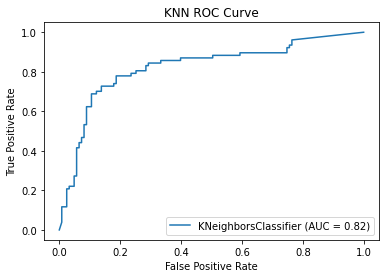

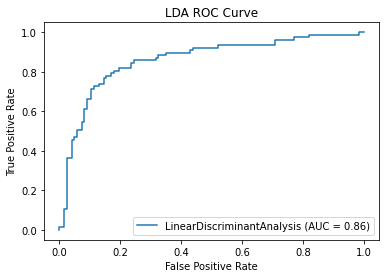

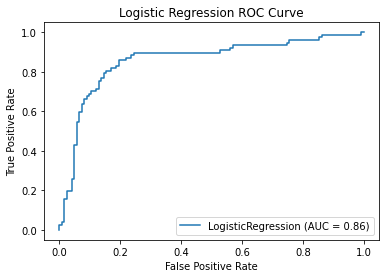

In [ ]:
roc_curve = roc(KNNClf, testX, testY)
plt.title("KNN ROC Curve")
roc_curve1 = roc(LDAClf, testX, testY)
plt.title("LDA ROC Curve")
roc_curve2 = roc(LogisticCLF, testX, testY)
plt.title("Logistic Regression ROC Curve")
plt.show()

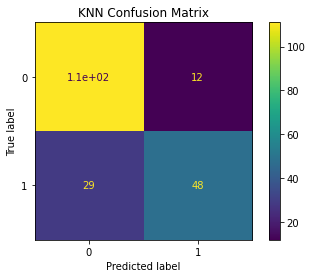

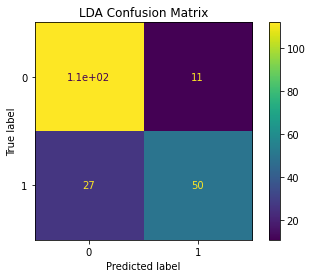

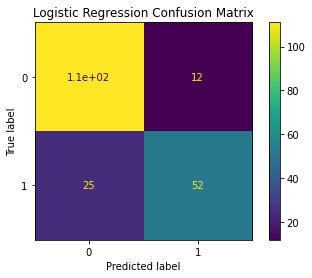

In [ ]:
confusion_matrix = sklearn.metrics.plot_confusion_matrix(KNNClf, testX, testY)
plt.title("KNN Confusion Matrix")
plt.show()
confusion_matrix1 = sklearn.metrics.plot_confusion_matrix(LDAClf, testX, testY)
plt.title("LDA Confusion Matrix")
plt.show()
confusion_matrix2 = sklearn.metrics.plot_confusion_matrix(LogisticCLF, testX, testY)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

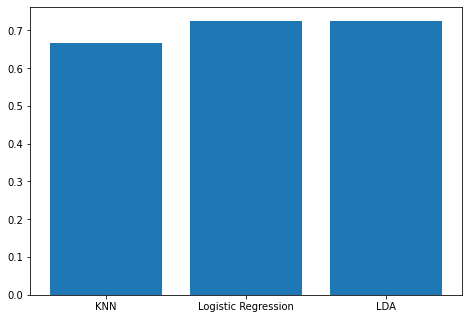

In [ ]:
##AVERAGE F1 Scores
fig = plt.figure()
fig.xlabel = "Classification Method"
fig.ylabel = "Average F1 Scores"
ax = fig.add_axes([0,0,1,1])
labels = ['KNN', 'Logistic Regression', 'LDA']
values = [KNN_F1, LR_F1, LDA_F1]
ax.bar(labels, values)
plt.show()



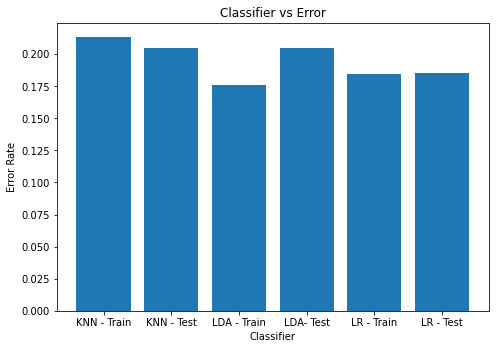

In [ ]:
fig = plt.figure()
fig.xlabel = "Classification Method"
fig.ylabel = "Average Training Error"
ax = fig.add_axes([0,0,1,1])
labels = ['KNN - Train','KNN - Test',   'LDA - Train', 'LDA- Test', 'LR - Train', 'LR - Test']
values = [KNN_Errors, KNN_TestError, LDA_Errors, LDA_TestError, LR_TrainingError, LR_TestError]
plt.ylabel('Error Rate')
plt.xlabel('Classifier')
plt.title('Classifier vs Error')
ax.bar(labels, values)
plt.show()

ROC Curves, confusion matrices, F1 score and Average Squared Mean Error are shown above. All the classifiers performed very well and judging by the F1 error (due to unbalance) Logistic Regression and LDA performed the best. KNN followed with a small error. LR had the least test error whilr KNN and LDA seemed to have about the same test dataset errors. And Confusion matrix shows TP, TN, FP, FN for all classes. ROC curves properly show the True positive and False positive rates (clearly shows LR and LDA performs very similar).

###f

Ethical issues under this dataset would include copyright concerns. 
The dataset contains raw text from many different article sites and it could be possible that during the time of fetching all this data, the data collector did not have the rights to add it to the dataset or the articles were used without paying for them (illegally obatined using piracy). It could also have problems with not properly citing the authors or the source when using it. So, all this could possibly lead to problems in the future if not properly handled.

###g


@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}

Weblinks:

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://scikit-learn.org/stable/modules/neighbors.html#classification

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html


Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python. PeerJ 2:e453 (2014)
2

Edward Loper and Steven Bird. 2002. NLTK: the Natural Language Toolkit. In Proceedings of the ACL-02 Workshop on Effective tools and methodologies for teaching natural language processing and computational linguistics - Volume 1 (ETMTNLP '02). Association for Computational Linguistics, USA, 63–70. DOI:https://doi.org/10.3115/1118108.1118117

  
Steven Bird, Ewan Klein, and Edward Loper (2009). Natural Language Processing with Python. O’Reilly Media Inc. http://nltk.org/book

https://www.nltk.org/py-modindex.html